In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import os
import pyro
from pyro.optim import Adam, ClippedAdam
from pyro.infer import TraceMeanField_ELBO, TraceEnum_ELBO, TraceGraph_ELBO, Trace_ELBO

import matplotlib.pyplot as plt
import numpy as np
import pickle

os.chdir('/Users/lucreziavaleriani/Documents/GitHub/LOCATE/')

/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
with open('./data/data.pkl', 'rb') as data:
    data_input = pickle.load(data)

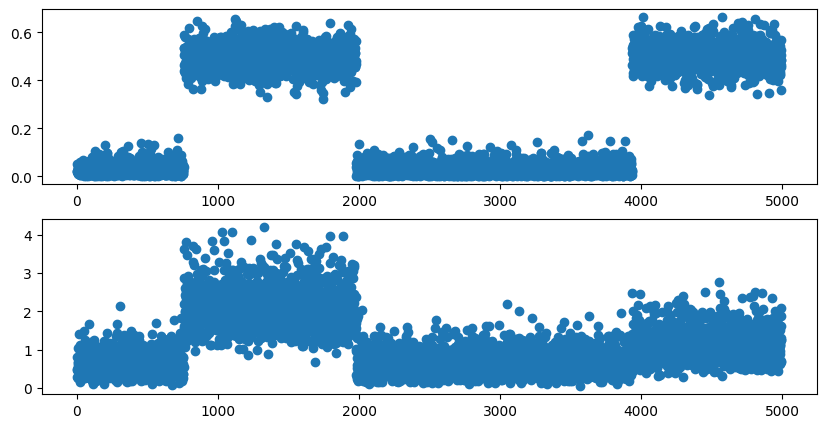

In [4]:
fig, axs = plt.subplots(2, figsize=(10, 5))
axs[0].plot(range(len(data_input['baf'])), data_input['baf'], 'o')
axs[1].plot(range(len(data_input['dr'])), data_input['dr'], 'o')

In [5]:
import locate as l
from locate.models import Clonal

In [20]:
locate = l.LOCATE(CUDA = False)

locate.set_model(Clonal)
locate.set_optimizer(ClippedAdam)
locate.set_loss(TraceEnum_ELBO)
locate.initialize_model({"baf": data_input["baf"], "dr": data_input["dr"], "vaf": None})
locate.set_model_params({"jumping_prob" : 1e-6})

In [25]:
ll = locate.run(steps = 120, param_optimizer = {"lr":0.1})

/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/pyro/infer/traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(
ELBO: 21934.703125000  : 100%|██████████| 120/120 [00:01<00:00, 68.14it/s]


Done!


In [26]:
bau = locate.learned_parameters()

In [27]:
bau

{'probs_x': array([[9.6449172e-01, 3.5485111e-02, 6.6835623e-06, 9.7763468e-06,
         6.6835496e-06],
        [3.5500668e-02, 9.6447623e-01, 6.6811094e-06, 9.7724333e-06,
         6.6811094e-06],
        [4.4861472e-06, 4.4861472e-06, 9.4459277e-01, 1.1323464e-04,
         5.5284943e-02],
        [8.1169965e-05, 8.1170045e-05, 4.8139361e-01, 3.3871070e-02,
         4.8457301e-01],
        [4.4773765e-06, 4.4773765e-06, 5.5051032e-02, 1.1296284e-04,
         9.4482702e-01]], dtype=float32),
 'baf_n_trial': array(39.72411, dtype=float32),
 'dr_n_trial': array(1.0540259, dtype=float32),
 'CN_Major': array([1, 1, 1, ..., 2, 2, 2]),
 'CN_minor': array([0, 0, 0, ..., 2, 2, 2])}

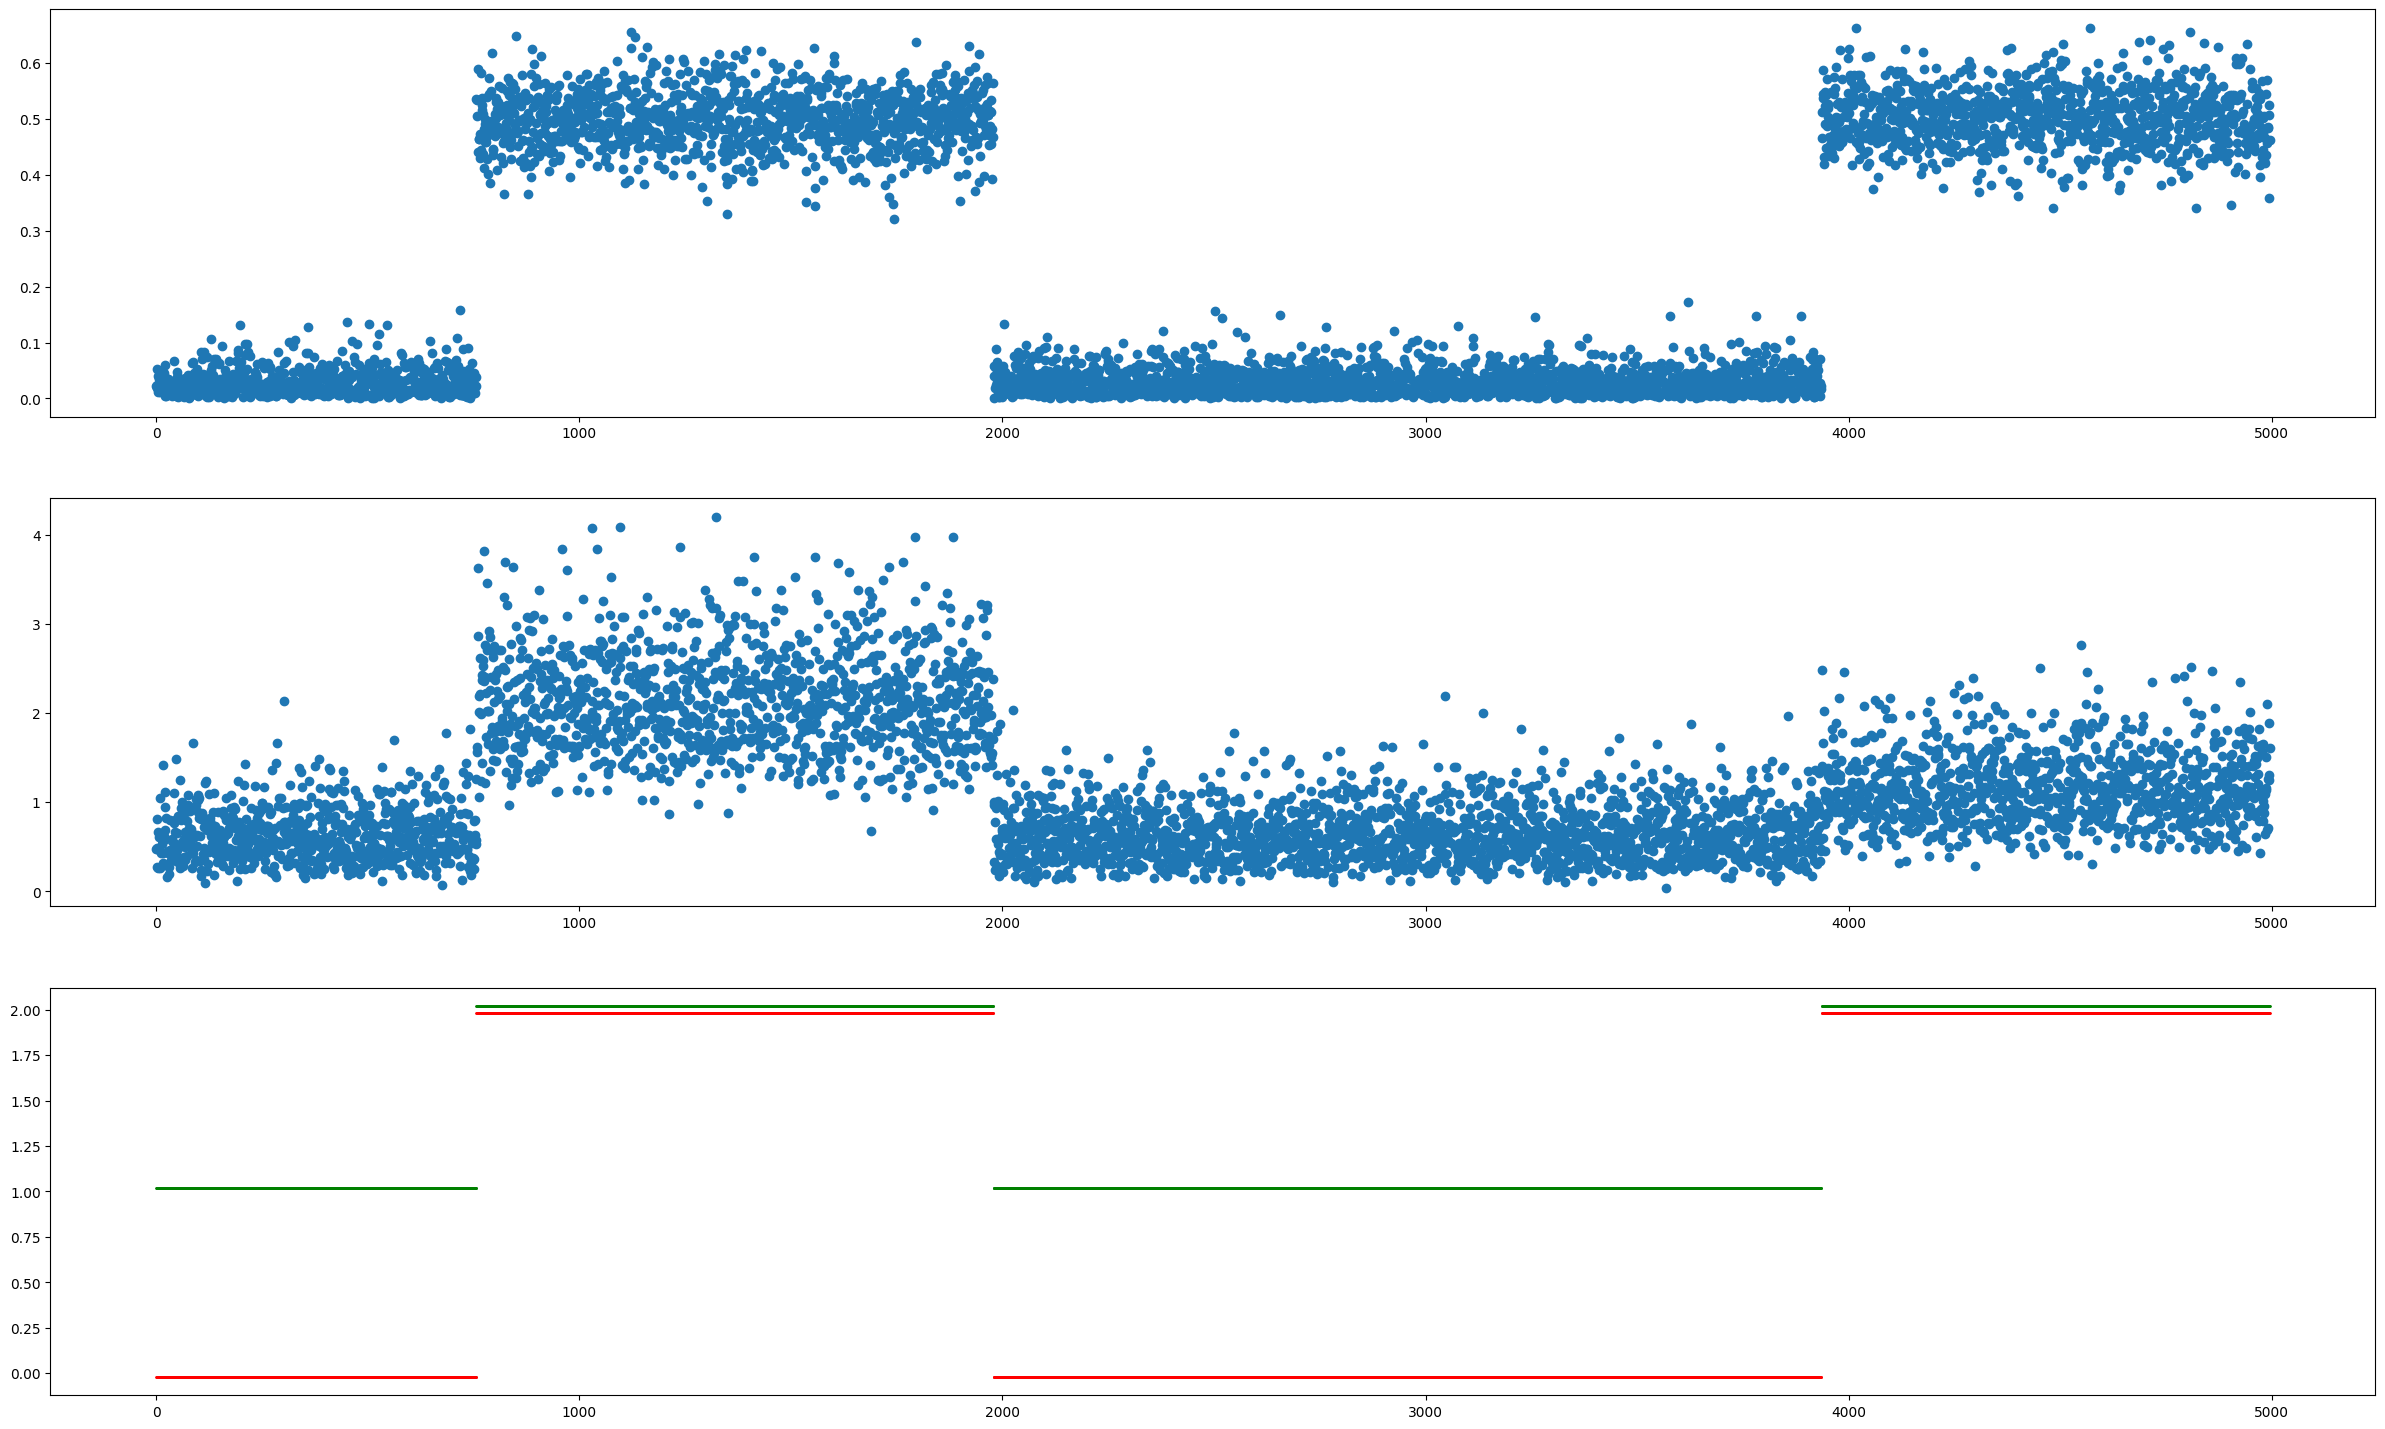

In [28]:
fig, axs = plt.subplots(3, figsize=(30, 18))
axs[0].plot(range(len(bau["CN_Major"])), data_input["baf"], 'o')
axs[1].plot(range(len(bau["CN_Major"])), data_input["dr"], 'o')
axs[2].plot(range(len(bau["CN_Major"])), bau["CN_Major"] + 0.02, 'o', color='green', markersize = 1)
axs[2].plot(range(len(bau["CN_minor"])), bau["CN_minor"] - 0.02, 'o', color='red', markersize = 1)